In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import statsmodels.tsa.api as smt
from pylab import rcParams

In [2]:
#Set style
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 12, 7

### Stage 1 : Preprocessing
The steps involved in this stage are:
    1. Removing any unwanted columns
    2. Check and fill missing values
    3. Checking the data types and process it accordingly
    4. Fixing outliers
    5. Set Date as index
    6. Feature engineering 

In [3]:
data = pd.read_csv('data.csv')

data is from a UK online retailer store.

##### Data Examining

In [4]:
#Execution Code
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Our dataset looks fine, however there are somethings which we need to change such as the Date format and the index. To make our dataset a time series based dataset the index will have to be changed.

In [5]:
#Execution Code
data.shape

(541909, 8)

We have here more than 500k rows of data.

#### Check for missing values

In [6]:
#Execution Code
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are a lot of missing values in the customerID and the Description column. The quantity of missive value is so high that conventional ways of replacing the missing values with the average is no longer possbile. That is why we decided to drop the rows with missing values.

In [7]:
#Execution Code
data.dropna(how='any', inplace=True)

In [8]:
#Check result code
data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
data.shape

(406829, 8)

There are no more missing values in our dataset, and we have around 400k of data left.

##### Check Data Types

In [10]:
#Execution Code
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

The type of our InvoiceDate needs to be changed to DateTimeIndex.

##### Change data type

In [11]:
#Execution code
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], infer_datetime_format=True)

In [12]:
#Check result code
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

The date now is in the correct format.

##### Fixing outliers

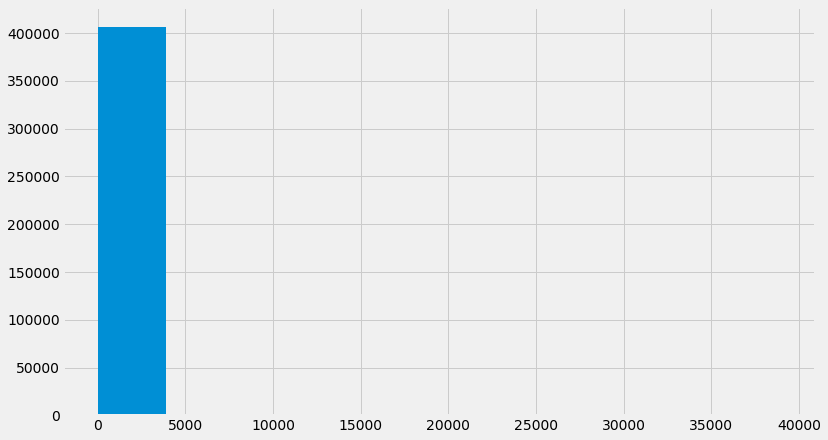

In [13]:
#Execution Code
data['UnitPrice'].hist(bins=10);

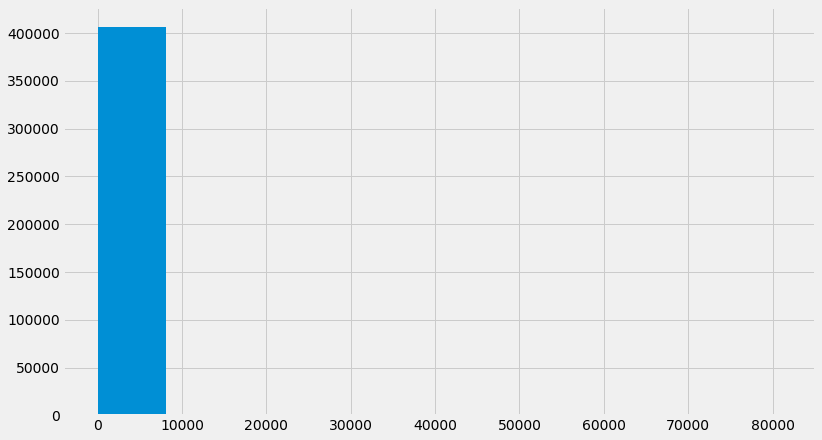

In [14]:
#Execution Code
data['Quantity'].hist(bins=10);

Using histograms, we can see that there is something clealy wrong with our data, there are huge outliers that are affecting our overall data. We now need to find and remove them.

In [15]:
temp = data[data['UnitPrice']>10000].index
temp2 = data[data['Quantity']>10000].index

data.drop(temp, inplace=True)
data.drop(temp2, inplace=True)

##### Set Date as index

Date is now formatted to the correct format. Now we can set it as our index, so we can use time series analysis models on it.

In [16]:
#Execution code
data = data.set_index('InvoiceDate')

In [17]:
#Check result code
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


##### Feature Engieering

We will be creating a new feature called revenue, which is the price of the item multiplied by the quantity purchased.

In [18]:
#Execution Code
data['Revenue'] = data['UnitPrice'] * data['Quantity']

In [19]:
#Check result code
data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Revenue
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34


### Stage 2 : Data Analysis and forecasting

In [20]:
earliest_entry = data.Revenue['2010-12-01 08:00:00':'2010-12-01 12:00:00']
lastest_entry = data.Revenue['2011-01-04 8:00:00':'2011-01-04 12:00:00']

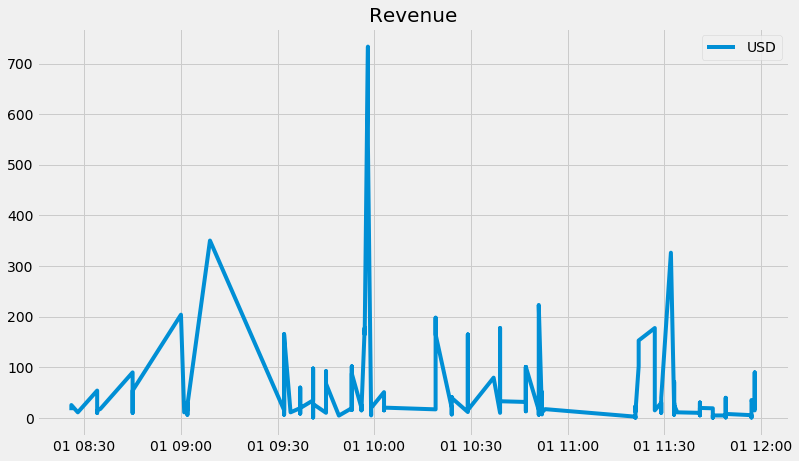

In [21]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(earliest_entry, label= 'USD');
ax.legend()

This is our revenue data in the earliest month of data entry.

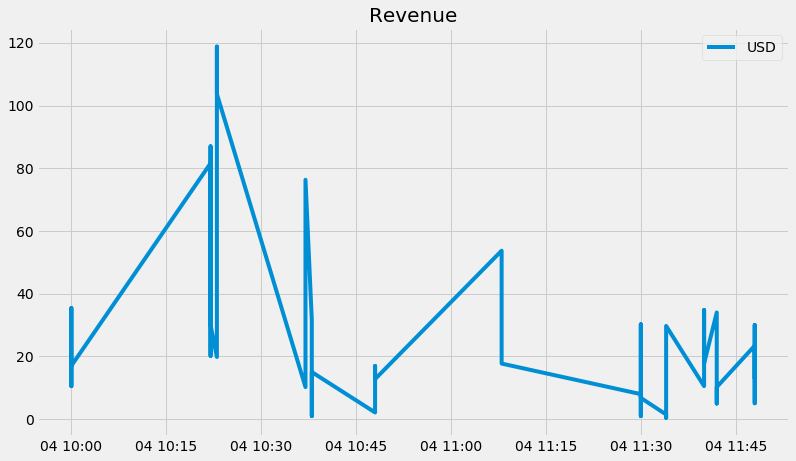

In [22]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(lastest_entry, label= 'USD');
ax.legend()

This is our data in the latest month of data entry.

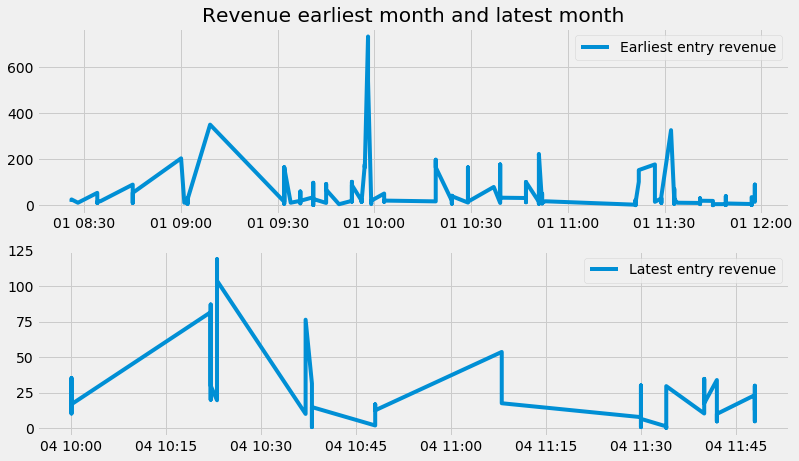

In [23]:
#Visualizing code

fig,ax = plt.subplots(2)

ax[0].set_title('Revenue earliest month and latest month')

ax[0].plot(earliest_entry, label='Earliest entry revenue')
ax[1].plot(lastest_entry, label='Latest entry revenue')

ax[0].legend()
ax[1].legend()
plt.show();

In [24]:
x = data['Revenue'].resample('MS').mean()

In [25]:
y = data['Revenue'].resample('D').mean()

In [26]:
z = data['Revenue'].resample('h').mean()

In [27]:
x.fillna(y.mean(), inplace=True)

In [28]:
y.fillna(y.mean(), inplace=True)

In [29]:
z.fillna(y.mean(), inplace=True)

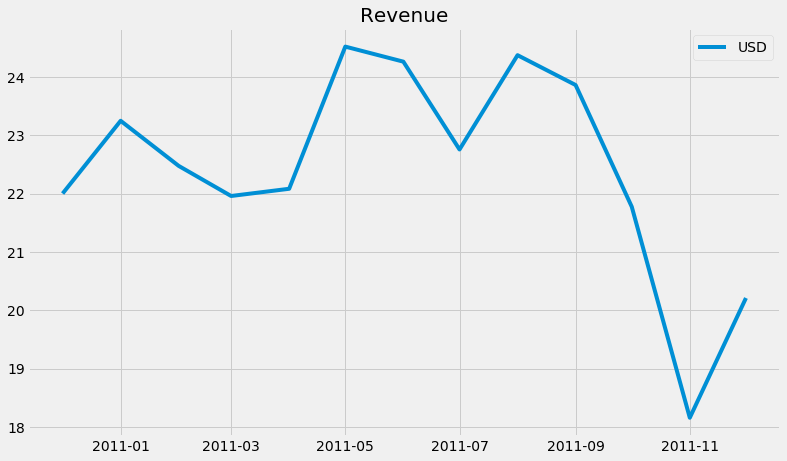

In [30]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(x, label= 'USD');
ax.legend()

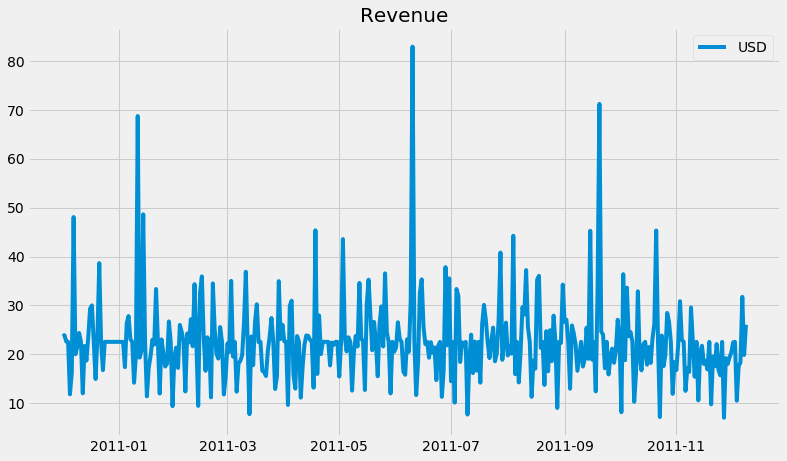

In [31]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(y, label= 'USD');
ax.legend()

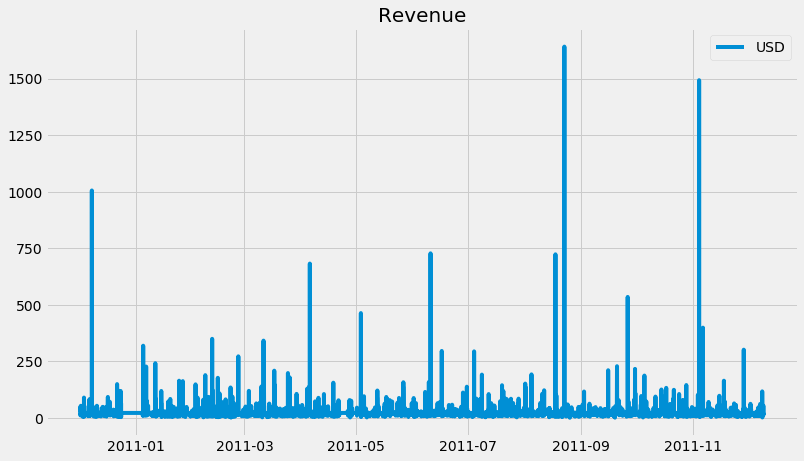

In [32]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(z, label= 'USD');
ax.legend()

#### Monthly forecasting

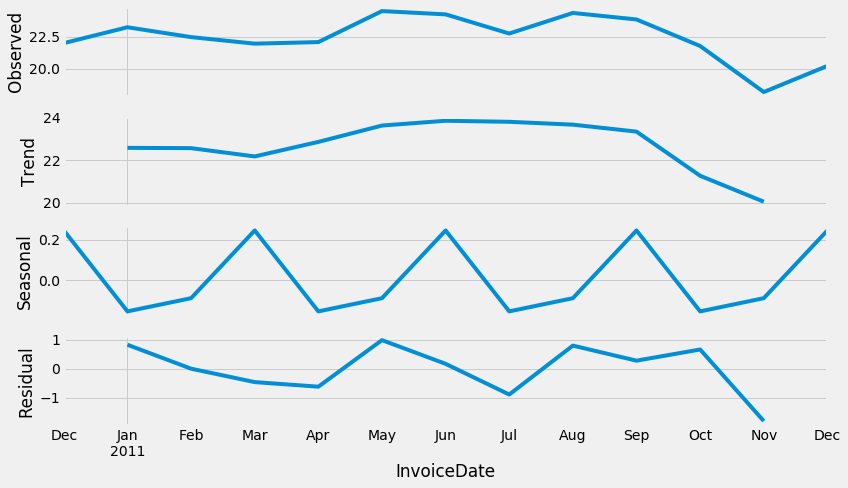

In [33]:
#Visualizing code
decomposition = smt.seasonal_decompose(x, model='additive', freq=3)
fig = decomposition.plot()
plt.show()

In [34]:
#Execution Code

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [35]:
#Surpress Warnings
warnings.filterwarnings('ignore')

#Execution Code
def optimize_SARIMA(parameters_list, d, D, s):
    
    results = [pd.np.empty((2))]
    
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = SARIMAX(x, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            model_SARIMA = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s);

In [36]:
#Exectution Code

#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[1]

model_SARIMA = SARIMAX(x, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=False)

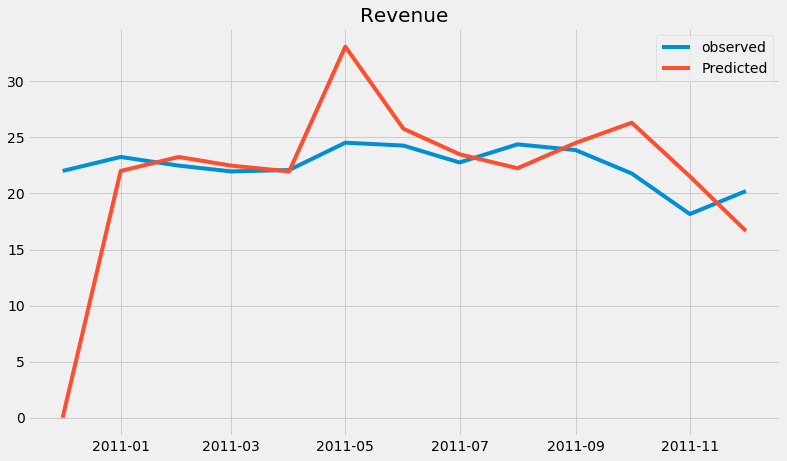

In [37]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(x, label='observed')
ax.plot(model_SARIMA.predict(), label = 'Predicted')
ax.legend();

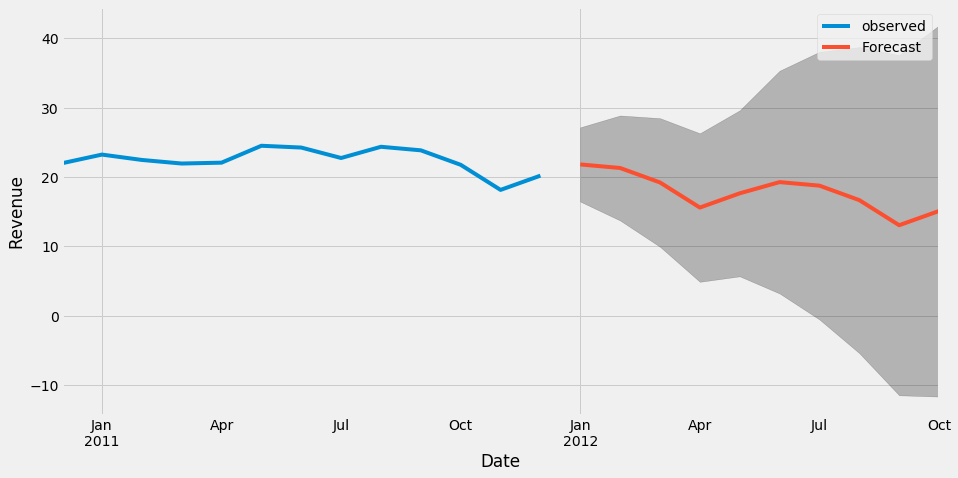

In [38]:
#Visualizing code
pred_uc = model_SARIMA.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = x.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [39]:
#Execution Code
y_true = x
y_pred_SARIMA = model_SARIMA.predict()

#Fiding the MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Finding the MAPA
Accuracy_SARIMA = 100 - mean_absolute_percentage_error(y_true, y_pred_SARIMA)

print('SARIMA: ', Accuracy_SARIMA)

SARIMA:  82.74114342835965


#### Daily forecasting

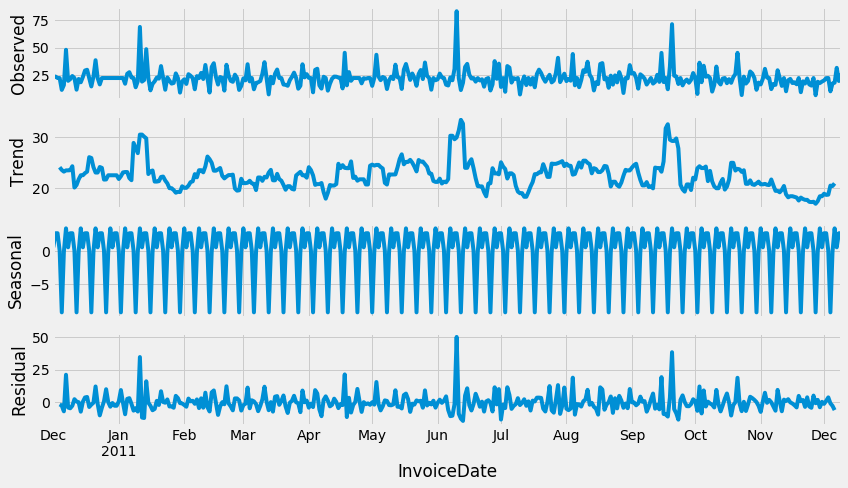

In [40]:
#Visualizing code
decomposition = smt.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

We can see from the decomposition that our data has seasonality.

In [41]:
#Execution Code

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [42]:
#Surpress Warnings
warnings.filterwarnings('ignore')

#Execution Code
def optimize_SARIMA(parameters_list, d, D, s):
    
    results = [pd.np.empty((2))]
    
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = SARIMAX(y, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            model_SARIMA = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s);

In [43]:
#Exectution Code

#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[1]

model_SARIMA = SARIMAX(y, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=False)

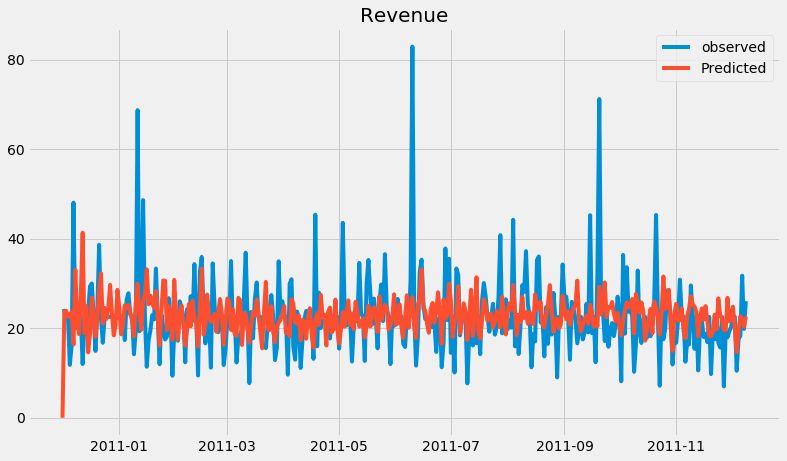

In [44]:
#Visualizing code
plt.figure()

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(y, label='observed')
ax.plot(model_SARIMA.predict(), label = 'Predicted')
ax.legend();

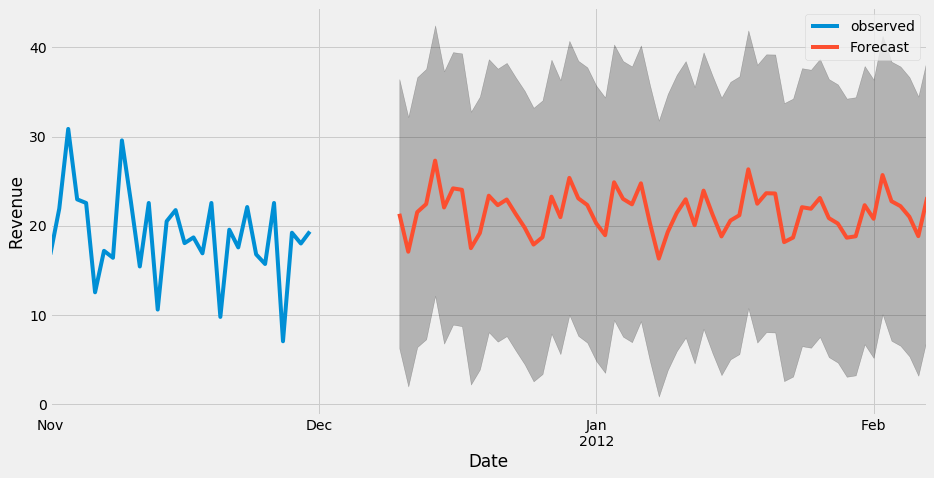

In [45]:
#Visualizing code
pred_uc = model_SARIMA.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = y['2011-11'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [46]:
#Execution Code
y_true = y
y_pred_SARIMA = model_SARIMA.predict()

#Fiding the MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Finding the MAPA
Accuracy_SARIMA = 100 - mean_absolute_percentage_error(y_true, y_pred_SARIMA)

print('SARIMA: ', Accuracy_SARIMA)

SARIMA:  72.79468376210735


#### hourly forecast

In [47]:
#Execution Code

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [48]:
#Surpress Warnings
warnings.filterwarnings('ignore')

#Execution Code
def optimize_SARIMA(parameters_list, d, D, s):
    
    results = [pd.np.empty((2))]
    
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = SARIMAX(z, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            model_SARIMA = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s);

In [49]:
#Exectution Code

#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[1]

model_SARIMA = SARIMAX(z, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=False)

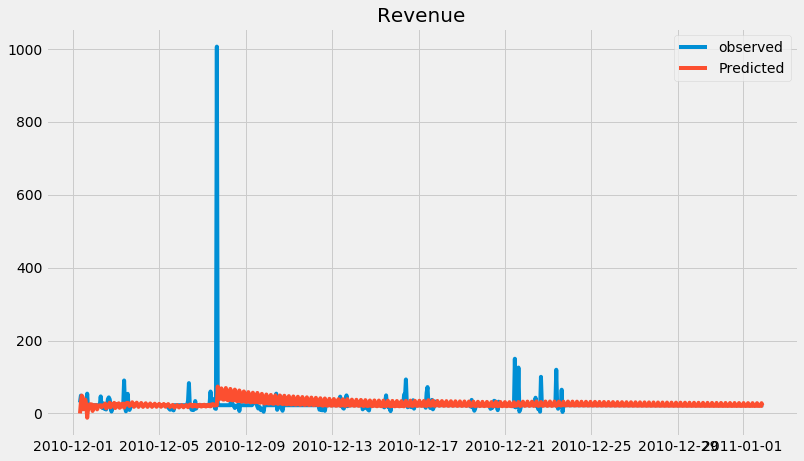

In [57]:
#Visualizing code
plt.figure()
temp = pd.DataFrame(model_SARIMA.predict())

ax = plt.axes()
ax.set_title('Revenue', fontsize=20)
ax.plot(z['2010-12-01':'2011-01-01'], label='observed')
ax.plot(temp['2010-12-01':'2011-01-01'], label = 'Predicted')
ax.legend();

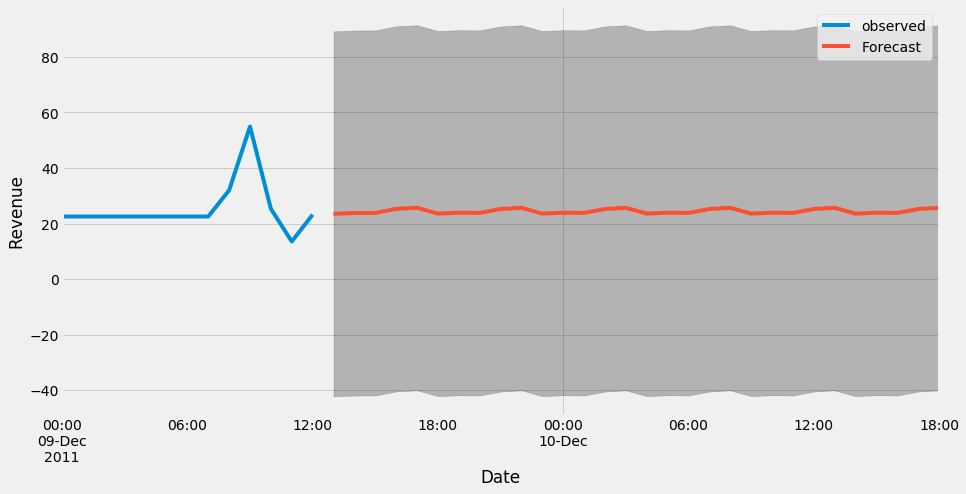

In [64]:
#Visualizing code
pred_uc = model_SARIMA.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = z['2011-12-09'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

In [52]:
#Execution Code
y_true = z
y_pred_SARIMA = model_SARIMA.predict()

#Fiding the MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Finding the MAPA
Accuracy_SARIMA = 100 - mean_absolute_percentage_error(y_true, y_pred_SARIMA)

print('SARIMA: ', Accuracy_SARIMA)

SARIMA:  71.08504068092368


#### Forecasting product category